In [2]:
from datasets import load_dataset
from datetime import datetime, timezone
from dateutil import parser

ds = load_dataset("alpindale/two-million-bluesky-posts", split="train")

/Users/work/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [3]:
print("First post:\n", ds[0])

First post:
 {'text': "This is really interesting polling data about national public attitudes re: California.  It's from the LA Times, in January.  I wonder if this will change substantially in the next two years?  5233025.fs1.hubspotusercontent-na1.net/hubfs/523302...", 'created_at': '2024-11-27T07:53:47.202Z', 'author': 'did:plc:5ug6fzthlj6yyvftj3alekpj', 'uri': 'at://did:plc:5ug6fzthlj6yyvftj3alekpj/app.bsky.feed.post/3lbw33zxvik24', 'has_images': False, 'reply_to': None}


In [4]:
start_time = datetime(2024, 11, 27, 7, 0, 0, tzinfo=timezone.utc)
end_time   = datetime(2024, 11, 27, 8, 0, 0, tzinfo=timezone.utc)

def in_target_hour(example):
    # Replace trailing 'Z' with '+00:00'
    aware_str = example["created_at"].replace("Z", "+00:00")
    dt = parser.isoparse(aware_str)  # <-- dateutil's tolerant parser
    return start_time <= dt < end_time

subset_time = ds.filter(in_target_hour)
# If you have predicted_language, filter to English:
def is_english(example):
    return example.get('predicted_language', '') == 'en'

if 'predicted_language' in ds.column_names:
    subset_en = subset_time.filter(is_english)
    print(f"\nFound {len(subset_en)} English posts in the hour 07:00–08:00.\n")
    for i in range(min(3, len(subset_en))):
        print(subset_en[i])
else:
    print(f"\nFound {len(subset_time)} posts in the hour 07:00–08:00 (no language predictions available).\n")
    for i in range(min(3, len(subset_time))):
        print(subset_time[i])


Found 16866 posts in the hour 07:00–08:00 (no language predictions available).

{'text': "This is really interesting polling data about national public attitudes re: California.  It's from the LA Times, in January.  I wonder if this will change substantially in the next two years?  5233025.fs1.hubspotusercontent-na1.net/hubfs/523302...", 'created_at': '2024-11-27T07:53:47.202Z', 'author': 'did:plc:5ug6fzthlj6yyvftj3alekpj', 'uri': 'at://did:plc:5ug6fzthlj6yyvftj3alekpj/app.bsky.feed.post/3lbw33zxvik24', 'has_images': False, 'reply_to': None}
{'text': 'Niet been, iets.', 'created_at': '2024-11-27T07:53:46.656Z', 'author': 'did:plc:xfvxxrfblwuc3kdthl344vc5', 'uri': 'at://did:plc:xfvxxrfblwuc3kdthl344vc5/app.bsky.feed.post/3lbw33zh7cs2l', 'has_images': False, 'reply_to': 'at://did:plc:fwjmfthdu5wppad75pcgpalj/app.bsky.feed.post/3lbvzv3tuc226'}
{'text': 'よく考えたらchrがsbさんの腰を両脚で挟んでどうこうとかポストしてたな\nいまさらだった……', 'created_at': '2024-11-27T07:53:46.554Z', 'author': 'did:plc:33m5bavcbydbgxqv7lzukclo'

In [5]:
import os
import asyncio
import json
import numpy as np
from getpass import getpass

from huggingface_hub import (
    notebook_login,
    create_inference_endpoint,
    list_inference_endpoints,
    whoami
)
from datasets import load_dataset
from dateutil import parser
from datetime import datetime, timezone
from tqdm import tqdm

In [6]:
notebook_login()

who = whoami()
print("Currently logged in as:", who["name"])

# If you belong to an org, and want to charge it instead of your personal account,
# you can prompt for it or just set it manually here:
# organization = getpass("What is your Hugging Face 🤗 organization (with payment method)? ")
# namespace = organization or who["name"]
namespace = who["name"]  # or an organization name

Currently logged in as: amuralit


In [ ]:
##
# 2. Create/Load an Inference Endpoint
##
ENDPOINT_NAME = "my-bluesky-embedding-endpoint"

# These were used in Derek's tutorial:
VENDOR = "aws"
REGION = "us-east-1"
INSTANCE_SIZE = "x1"         # Single GPU
INSTANCE_TYPE = "nvidia-a100"

MAX_WORKERS = 5  # How many async workers (and a factor in how many tokens we can handle at once)

# Create or load the Inference Endpoint
try:
    endpoint = create_inference_endpoint(
        name=ENDPOINT_NAME,
        repository="jinaai/jina-embeddings-v2-base-en",
        revision="7302ac470bed880590f9344bfeee32ff8722d0e5",
        task="sentence-embeddings",
        framework="pytorch",
        accelerator="gpu",
        instance_size=INSTANCE_SIZE,
        instance_type=INSTANCE_TYPE,
        region=REGION,
        vendor=VENDOR,
        namespace=namespace,
        custom_image={
            "health_route": "/health",
            "env": {
                "MAX_BATCH_TOKENS": str(MAX_WORKERS * 2048),
                "MAX_CONCURRENT_REQUESTS": "512",
                "MODEL_ID": "/repository",
            },
            "url": "ghcr.io/huggingface/text-embeddings-inference:0.5.0",
        },
        type="protected",
    )
    print(f"Created new endpoint: {ENDPOINT_NAME}")
except Exception as e:
    # If the endpoint already exists, we load it from the list
    print("Endpoint already exists or could not be created, loading existing endpoint...")
    endpoint = [ie for ie in list_inference_endpoints(namespace=namespace) if ie.name == ENDPOINT_NAME][0]

# Wait until the endpoint is running
print("\nWaiting for endpoint to be running...")
endpoint.wait()
print("Endpoint is running!\n")

InferenceEndpointError: Inference Endpoint bluesky-trajectory-embedding-4 failed to deploy. Please check the logs for more information.

In [36]:
##
# 4. Embed one sample text from subset_en
##
example_to_embed = subset_time[0]["text"]
print("Embedding this text:\n", example_to_embed)

# Send the text to your Inference Endpoint
response_bytes = endpoint.client.post(
    json={
        "inputs": example_to_embed,
        "truncate": True  # If text is too long, we truncate it
    },
    task="feature-extraction",
)
# Convert response from bytes -> JSON -> NumPy array
embedding_array = np.array(json.loads(response_bytes.decode()))

print("\nEmbedded vector shape:", embedding_array.shape)
print("First 10 values of the embedding:\n", embedding_array[0][:10])


Embedding this text:
 This is really interesting polling data about national public attitudes re: California.  It's from the LA Times, in January.  I wonder if this will change substantially in the next two years?  5233025.fs1.hubspotusercontent-na1.net/hubfs/523302...

Embedded vector shape: (1, 768)
First 10 values of the embedding:
 [-0.04396782 -0.07015993  0.0708933   0.03038285 -0.02132038 -0.0295447
  0.01466758 -0.0439329   0.06275629  0.02437612]


In [39]:
# %%
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

def safe_text(txt, max_chars=5000):
    txt = txt.strip()
    # If empty after stripping, replace with placeholder
    if not txt:
        return "EMPTY_TEXT"
    # Truncate extremely long text
    return txt[:max_chars]

BATCH_SIZE = 2  # Start small

all_embeddings = []
for start_idx in tqdm(range(0, len(subset_time), BATCH_SIZE)):
    batch = subset_time[start_idx : start_idx + BATCH_SIZE]
    # Clean + truncate texts
    batch_texts = [safe_text(txt) for txt in batch["text"]]

    # Send the batch to the endpoint
    response_bytes = endpoint.client.post(
        json={
            "inputs": batch_texts,
            "truncate": True,  # At the model level
        },
        task="feature-extraction",
    )
    batch_embeddings = np.array(json.loads(response_bytes.decode()))
    for row_emb in batch_embeddings:
        all_embeddings.append(row_emb)

df_time = subset_time.to_pandas()
df_time["embedding"] = [emb.tolist() for emb in all_embeddings]

df_time.to_csv("subset_time_embedded.csv", index=False)
print(f"Saved {len(df_time)} posts (with embeddings) to subset_time_embedded.csv.")

100%|██████████| 8433/8433 [15:32<00:00,  9.04it/s]


Saved 16866 posts (with embeddings) to subset_time_embedded.csv.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the font cache; this may take a moment.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

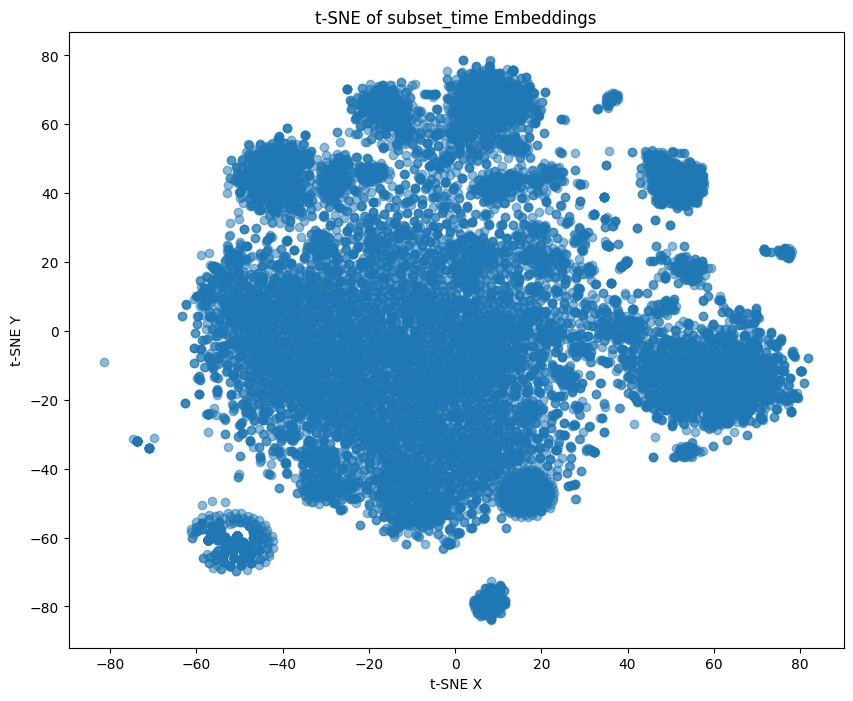

In [43]:
# %%
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert the list of embeddings into a NumPy array
embeddings = np.vstack(df_time["embedding"].values)

# Instantiate t-SNE; feel free to adjust parameters (e.g., perplexity, metric, etc.)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, metric='cosine')

# Fit and transform the embeddings to 2D
embeddings_2d = tsne.fit_transform(embeddings)

# Add the X and Y coordinates back to df_time
df_time["x"] = embeddings_2d[:, 0]
df_time["y"] = embeddings_2d[:, 1]

# Plot the 2D scatter of t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(df_time["x"], df_time["y"], alpha=0.5)
plt.title("t-SNE of subset_time Embeddings")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.show()


/Users/work/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/work/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/work/Library/Python/3.9/lib/python/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


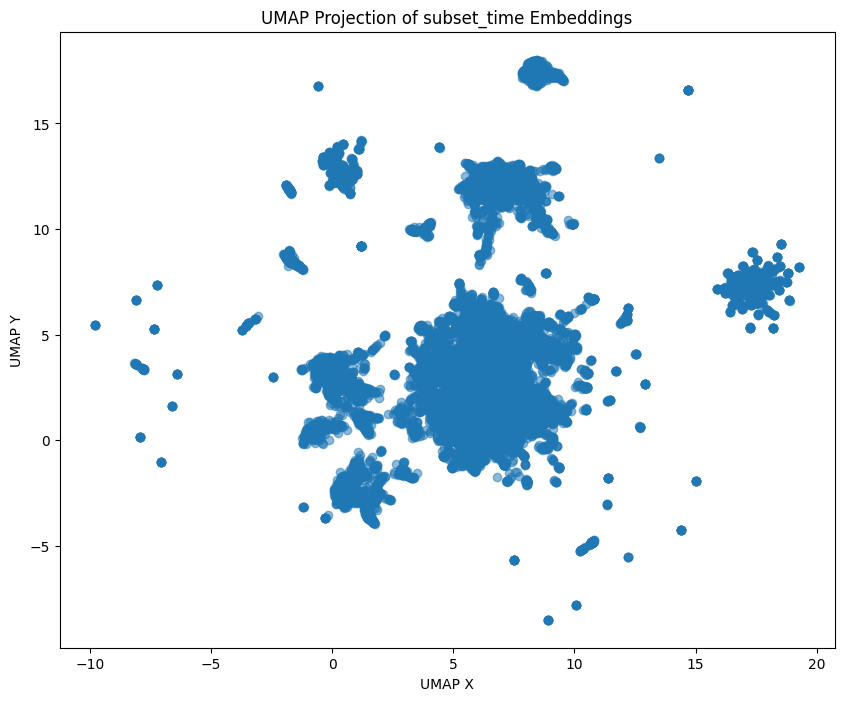

In [45]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Convert embeddings column to a NumPy array if it isn't already
embeddings = np.vstack(df_time["embedding"].values)

# Instantiate UMAP
umap_model = umap.UMAP(
    n_neighbors=5,      # You can experiment with different values, e.g. 5, 15, 30
    n_components=2,      # 2D for easy plotting
    metric='cosine',     # Cosine distance often works well for text embeddings
    random_state=42      # For reproducibility
)

# Fit and transform the embeddings
umap_embeddings_2d = umap_model.fit_transform(embeddings)

# Store the result in df_time
df_time["umap_x"] = umap_embeddings_2d[:, 0]
df_time["umap_y"] = umap_embeddings_2d[:, 1]

# Plot the result
plt.figure(figsize=(10, 8))
plt.scatter(df_time["umap_x"], df_time["umap_y"], alpha=0.5)
plt.title("UMAP Projection of subset_time Embeddings")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.show()